In [72]:
%load_ext autoreload
%autoreload 2

import os
import respy as rp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle as pkl

from collections import OrderedDict
from collections import defaultdict

import respy as rp
#from respy.pre_processing.model_processing import process_params_and_options

from python.auxiliary import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Simulated Method of Moments estimation

**Outline**

This notebook explores a simulated method of moments (SMM) estimation for respy's simple Robinson Crusoe decision model. The notebook is divided into four major parts. The first part shows the model and generates the 'observed data' used for the estimation in all later parts. In the second part I generate the elements needed for a SMM estimation i.e. the moments that describe the observed data and the weighting matrix as well as the criterion function used for estimation. Part three constitutes a SMM estimation for a candidate parameter vector that deviates from the true parameter vector but uses simulated data based on the same simulation seed that is used to generate the observed data. Section four explores how estimation results change if we used a different simulation seed and alter the set of options used to generate the model.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Model-&amp;-Observed-Data" data-toc-modified-id="Model-&amp;-Observed-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Model &amp; Observed Data</a></span></li><li><span><a href="#Setup-for-SMM-Estimation" data-toc-modified-id="Setup-for-SMM-Estimation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Setup for SMM Estimation</a></span><ul class="toc-item"><li><span><a href="#Calculate-Moments" data-toc-modified-id="Calculate-Moments-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Calculate Moments</a></span><ul class="toc-item"><li><span><a href="#Function-for-calculating-moments" data-toc-modified-id="Function-for-calculating-moments-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Function for calculating moments</a></span></li><li><span><a href="#Observed-Moments" data-toc-modified-id="Observed-Moments-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>Observed Moments</a></span></li></ul></li><li><span><a href="#Weighting-Matrix" data-toc-modified-id="Weighting-Matrix-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Weighting-Matrix</a></span></li><li><span><a href="#Criterion-Function" data-toc-modified-id="Criterion-Function-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Criterion Function</a></span></li></ul></li><li><span><a href="#SMM-Estimation" data-toc-modified-id="SMM-Estimation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>SMM Estimation</a></span><ul class="toc-item"><li><span><a href="#Define-starting-paramters" data-toc-modified-id="Define-starting-paramters-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Define starting paramters</a></span></li><li><span><a href="#Simulated-Moments" data-toc-modified-id="Simulated-Moments-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Simulated Moments</a></span></li><li><span><a href="#Optimization-proceidure" data-toc-modified-id="Optimization-proceidure-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Optimization proceidure</a></span><ul class="toc-item"><li><span><a href="#Upper-and-Lower-Bounds" data-toc-modified-id="Upper-and-Lower-Bounds-3.3.1"><span class="toc-item-num">3.3.1&nbsp;&nbsp;</span>Upper and Lower Bounds</a></span></li><li><span><a href="#Constraints" data-toc-modified-id="Constraints-3.3.2"><span class="toc-item-num">3.3.2&nbsp;&nbsp;</span>Constraints</a></span></li><li><span><a href="#Optimize" data-toc-modified-id="Optimize-3.3.3"><span class="toc-item-num">3.3.3&nbsp;&nbsp;</span>Optimize</a></span></li><li><span><a href="#Plot-Criterion-Function" data-toc-modified-id="Plot-Criterion-Function-3.3.4"><span class="toc-item-num">3.3.4&nbsp;&nbsp;</span>Plot Criterion Function</a></span></li></ul></li></ul></li><li><span><a href="#Simulation-Study" data-toc-modified-id="Simulation-Study-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Simulation Study</a></span><ul class="toc-item"><li><span><a href="#Changing-the-Simulation-Seed" data-toc-modified-id="Changing-the-Simulation-Seed-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Changing the Simulation Seed</a></span></li></ul></li></ul></div>

**To do:**
   - Part 4
   - Add text and descriptions to all sections of the notebook
   - Implement algorithm for calculating the weighting matrix

##  Observed Data

Our model and data is given by [respy](https://respy.readthedocs.io/en/latest/)'s `robinson` example model. In this simple model, the agent, Robinson Crusoe, in each time period decides between two choice options: working (i.e. going fishing) or spending time in the hammock. We use the function `get_example_model `to simulate the model and a dataset.

For the remainder of this notebook we will treat these observations as though they are real observed data and try to recover the parameters of the model using this data. However, since this is actually a simulated model for which we know the true parameter vector, we will be able to compare how well our estimation procedures perform.

In [2]:
params_true, options, data_obs = rp.get_example_model("robinson", with_data=True)

Uncomment the lines of code below to take a look at the model specifications and observed data.

In [101]:
# params_true 

In [102]:
# options

In [103]:
# data_obs.head(10)

##  Setup for SMM Estimation
### Choice of Moments

For the setup of the estimation we first have to choose a set of moments that we will use to match the observed data and the simulated model. For this model we include two sets of moments. The first set are Robinson's choice probabilities (choice probabilities here refers to the share of agents that have chosen a specific option) for each period. The second set are moments that characterize the wage distribution for each period, i.e. the mean of the wage of all agents that have chosen fishing in a given period and the standard deviation of the wages. 

In [4]:
# Specify the potential choice options.
choice_options_robinson = ['fishing', 'hammock']

In [73]:
# Use a function to calculate the data moments.
moments_obs = get_moments(data_obs, choice_options_robinson)
print('Choice Probabilities')
print(moments_obs['Choice Probabilities'])
print('\n Wage Distribution')
print(moments_obs['Wage Distribution'])

Choice Probabilities
{0: [0.631, 0.369], 1: [0.631, 0.369], 2: [0.631, 0.369], 3: [0.631, 0.369], 4: [0.631, 0.369]}

 Wage Distribution
{0: [1.0037950532864608, 0.009222735533113452], 1: [1.0724623646069125, 0.010885774459361966], 2: [1.1506433910875764, 0.01165976621540699], 3: [1.2325871778674606, 0.01188724268886421], 4: [1.3230636324871103, 0.012512007111785479]}


### Weighting-Matrix

Next we specify a weighting matrix.

In [6]:
# I use the identity matrix for now.
identity_matrix = np.eye(20)
print(identity_matrix)

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.

### Criterion Function 

Criterion function at the true parameter vector.

In [7]:
fval = evaluate(params_true, options, identity_matrix, moments_obs, choice_options_robinson)
fval

0.0

We can plot the criterion function to examine its behavior around the minimum in more detail. The plots below show the criterion function at varying values of the parameter for delta. Each plot depicts the criterion function for a progressively smaller range to 'zoom in' on the true minimum value of 0.95 given by the true parameter vector. 

Criterion function for varying values of delta:

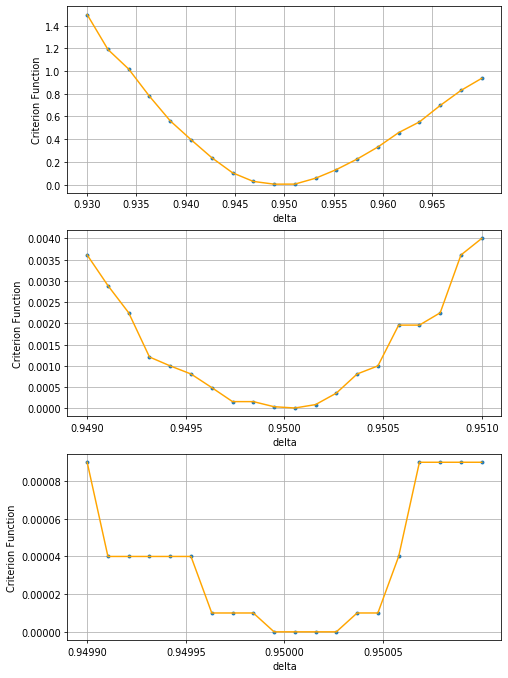

In [107]:
criterion_args = [options, identity_matrix, moments_obs, choice_options_robinson]
plot_criterion_fun(params_true, 
                   'delta', 
                   [0.93, 0.949, 0.9499], # lower bound
                   [0.97, 0.951, 0.9501], # upper bound
                   [0.005,0.0005, 0.00005], # xticks steps
                   20, # number of parameter values calculated (blue dots)
                   criterion_args) 


In [106]:
"""
# Criterion function for varying values of the wage_fishing
criterion_args = [options, identity_matrix, moments_obs, choice_options_robinson]
plot_criterion_fun(params_true, 
                   'wage_fishing', 
                   [0.068, 0.06999, 0.0699999], # lower bound
                   [0.074, 0.07001, 0.0700001], # upper bound
                   [0.0005, 0.000005, 0.00000005], # xticks steps
                   30, # number of parameter values calculated (blue dots)
                   criterion_args) """

"\n# Criterion function for varying values of the wage_fishing\ncriterion_args = [options, identity_matrix, moments_obs, choice_options_robinson]\nplot_criterion_fun(params_true, \n                   'wage_fishing', \n                   [0.068, 0.06999, 0.0699999], # lower bound\n                   [0.074, 0.07001, 0.0700001], # upper bound\n                   [0.0005, 0.000005, 0.00000005], # xticks steps\n                   30, # number of parameter values calculated (blue dots)\n                   criterion_args) "

## SMM Estimation

### Define starting parameters


In [99]:
# Define candidate parameters: For now we just change one parameter
params_cand = params_true.copy()
params_cand.loc['delta','value'] = 0.93

### Simulated Moments

In [100]:
params = params_cand.copy()
simulate = rp.get_simulate_func(params, options)
df_sim = simulate(params)
moments_sim = get_moments(df_sim, choice_options_robinson)

print('Choice Probabilities')
print(moments_sim['Choice Probabilities'])
print('\n Wage Distribution')
print(moments_sim['Wage Distribution'])

Choice Probabilities
{0: [0.244, 0.756], 1: [0.244, 0.756], 2: [0.244, 0.756], 3: [0.244, 0.756], 4: [0.244, 0.756]}

 Wage Distribution
{0: [1.0095149927160547, 0.008198290003548022], 1: [1.0728957195893678, 0.010514385733230281], 2: [1.1515521441487266, 0.011934344072283899], 3: [1.2330302273612044, 0.011737002476584076], 4: [1.3217938871844948, 0.013266040322672396]}


Function value for candidate parameters that differ from the true ones:

In [96]:
fval = evaluate(params_cand, options, identity_matrix, moments_obs, choice_options_robinson)
fval

1000000

### Optimization procedure

We will now use an optimization procedure to retrieve the true parameter vector. For the optimization I use [estimagic](https://estimagic.readthedocs.io/en/latest/index.html). Estimagic is a Python package that is developed to help implement (structural) econometric models and offers a variety of customization options for the optimization procedure as well as a large selection of algorithms.

We have verified above that the criterion function gives a value of 0 for the true parameter vector. Before we try different parameter specifications, we can check whether an optimizer recognizes the true vector as the minimum of our criterion function.

For our optimization procedure we need estimagic's *minimize* function.

In [13]:
from estimagic.optimization.optimize import minimize

As inputs for the *minimize* function we need to specify:
* the the criterion function we want to minimize
* the parameter vector with respect to which we want to minimize the criterion function
* one of the optimization [algorithms that estimagic supports](https://estimagic.readthedocs.io/en/latest/optimization/algorithms.html)
* possible other arguments of the criterion function (e.g. the weighting matrix or moments)

As the code below shows, the optimization algorithm recognizes the true parameter vector as the minimum of the criterion function.

In [14]:
rslt = minimize(criterion=evaluate,
                params=params_true,
                algorithm="nlopt_bobyqa",
                criterion_args=(options, identity_matrix, moments_obs, choice_options_robinson),
               )
rslt[0]

{'fun': 0.0, 'internal_x': [0.95, 0.07, -0.1, 1.046, 0.01, 0.01, 0.0]}

#### Upper and Lower Bounds

We can help the optimizer by specifying bounds for the parameters. Since we know the true parameters in the case of this model, the bounds are easy to specify. We just pick upper and lower bounds that are fairly close to the true values of the parameters to aid the optimizer in the search for the optimum. 

By default, the upper and lower bounds are set to $\infty$ and $-\infty$ so specifying upper and lower bounds substantially reduces the range of parameter values that the optimizer can potentially cover. Even if the true parameters are unknown, the model usually imposes certain restrictions and assumptions on the parameters that allows us to rule out many potential parameter values. For example, we can assume that the non-pecuniary value of fishing is negative because working is strenuous and thus causes Robinson disutility. 

We can specify bounds by adding the columns *'lower'* and *'upper'* to the dataframe that contains the parameter values.

In [15]:
# Lower and upper bound for parameters
params_cand['lower'] = [0.9, 0.068, -1.5, 1, 0, 0, 0]
params_cand['upper'] = [0.99, 0.072, 0, 2, 0.02, 0.02, 0.1]
params_cand

value  lower  upper
category       name                                     
delta          delta                 0.910  0.900  0.990
wage_fishing   exp_fishing           0.070  0.068  0.072
nonpec_fishing constant             -0.100 -1.500  0.000
nonpec_hammock constant              1.046  1.000  2.000
shocks_sdcorr  sd_fishing            0.010  0.000  0.020
               sd_hammock            0.010  0.000  0.020
               corr_hammock_fishing  0.000  0.000  0.100

#### Constraints
In addition to specifying bounds, estimagic allows us to set constraints for the optimization procedure. 

In [16]:
# Hold all values except the changed parameter fixed 
constr = [
    {"loc": "shocks_sdcorr", "type": "sdcorr"}, 
    #{"loc": "delta", "type": "fixed", "value": 0.95},
    {"loc": "wage_fishing", "type": "fixed", "value": 0.07},
    {"loc": "nonpec_fishing", "type": "fixed", "value": -0.1},
    {"loc": "nonpec_hammock", "type":"fixed", "value": 1.046},
    {"loc": ("shocks_sdcorr","sd_fishing"), "type": "fixed", "value": 0.01},
    {"loc": ("shocks_sdcorr","sd_hammock"), "type": "fixed", "value": 0.01},
    {"loc": ("shocks_sdcorr","corr_hammock_fishing"), "type": "fixed", "value": 0},  
]

#### Optimize

In [17]:
rslt = minimize(criterion=evaluate,
                params=params_cand,
                algorithm="nlopt_bobyqa",
                constraints=constr,
                criterion_args=(options,identity_matrix, moments_obs, choice_options_robinson),
                # dashboard=True # <-- uncommenting this code will launch a dashboard when this cell is run 
               )
rslt[0]

{'fun': 0.0, 'internal_x': [0.9500058887592011]}

## Simulation Alterations

In [18]:
params = params_cand.copy()
simulate = rp.get_simulate_func(params, options)
df_sim = simulate(params)
moments_sim = get_moments(df_sim, choice_options_robinson)

print('Choice Probabilities')
print(moments_sim['Choice Probabilities'])
print('\n Wage Distribution')
print(moments_sim['Wage Distribution'])

Choice Probabilities
{0: [0.057, 0.943], 1: [0.057, 0.943], 2: [0.057, 0.943], 3: [0.057, 0.943], 4: [0.057, 0.943]}

 Wage Distribution
{0: (1.0156309699098678, 0.007932476163958665), 1: (1.0727351346470868, 0.009457912896024212), 2: (1.1525543797774405, 0.011117292200387334), 3: (1.2321445274051062, 0.012130022654426299), 4: (1.3222517030491312, 0.013661788647947941)}


### Changing multiple parameters

In [49]:
params_true

value
category       name                       
delta          delta                 0.950
wage_fishing   exp_fishing           0.070
nonpec_fishing constant             -0.100
nonpec_hammock constant              1.046
shocks_sdcorr  sd_fishing            0.010
               sd_hammock            0.010
               corr_hammock_fishing  0.000

In [54]:
params = params_true.copy()
params.loc['delta', 'value'] = 0.92
params.loc['wage_fishing'] = 0.071
params.loc[('nonpec_fishing','value')] = -0.101
#params.loc[('nonpec_hammock','value')] = 1.1
#params.loc[("shocks_sdcorr","sd_fishing"),"value"] = 0.01
#params.loc[("shocks_sdcorr","sd_hammock"),"value"] = 0.01
#params.loc[("shocks_sdcorr","corr_hammock_fishing"), "value"] = 0

params['lower'] = [0.9, 0.068, -0.12, 1, 0, 0, 0]
params['upper'] = [0.99, 0.072, -0.08, 2, 0.02, 0.02, 0.1]
params

value  lower  upper
category       name                                     
delta          delta                 0.920  0.900  0.990
wage_fishing   exp_fishing           0.071  0.068  0.072
nonpec_fishing constant             -0.101 -0.120 -0.080
nonpec_hammock constant              1.046  1.000  2.000
shocks_sdcorr  sd_fishing            0.010  0.000  0.020
               sd_hammock            0.010  0.000  0.020
               corr_hammock_fishing  0.000  0.000  0.100

In [55]:
constr = [
    {"loc": "shocks_sdcorr", "type": "sdcorr"}, 
    #{"loc": "delta", "type": "fixed", "value": 0.95},
    #{"loc": "wage_fishing", "type": "fixed", "value": 0.07},
    #{"loc": "nonpec_fishing", "type": "fixed", "value": -0.1},
    {"loc": "nonpec_hammock", "type":"fixed", "value": 1.046},
    {"loc": ("shocks_sdcorr","sd_fishing"), "type": "fixed", "value": 0.01},
    {"loc": ("shocks_sdcorr","sd_hammock"), "type": "fixed", "value": 0.01},
    {"loc": ("shocks_sdcorr","corr_hammock_fishing"), "type": "fixed", "value": 0},  
]

rslt = minimize(criterion=evaluate,
                params=params,
                algorithm="nlopt_bobyqa",
                constraints=constr,
                criterion_args=(options,identity_matrix, moments_obs, choice_options_robinson),
                #dashboard=True
               )
rslt[0]

{'fun': 0.0040623000564829,
 'internal_x': [0.9387108461382648, 0.07113950856404778, -0.10091432361802705]}

In [56]:
rslt[1]

value  lower  upper           group  \
category       name                                                           
delta          delta                 0.938711  0.900  0.990  All Parameters   
wage_fishing   exp_fishing           0.071140  0.068  0.072  All Parameters   
nonpec_fishing constant             -0.100914 -0.120 -0.080  All Parameters   
nonpec_hammock constant              1.046000  1.000  2.000  All Parameters   
shocks_sdcorr  sd_fishing            0.010000  0.000  0.020  All Parameters   
               sd_hammock            0.010000  0.000  0.020  All Parameters   
               corr_hammock_fishing  0.000000  0.000  0.100  All Parameters   

                                                                   name  \
category       name                                                       
delta          delta                                        delta_delta   
wage_fishing   exp_fishing                     wage_fishing_exp_fishing   
nonpec_fishing constant                         nonpec_fishing_constant   
nonpec_hammock constant                         nonpec_hammock_constant   
shocks_sdcorr  sd_fishing                      shocks_sdcorr_sd_fishing   
               sd_hammock                      shocks_sdcorr_sd_hammock   
               corr_hammock_fishing  shocks_sdcorr_corr_hammock_fishing   

                                     _fixed  
category       name                          
delta          delta                  False  
wage_fishing   exp_fishing            False  
nonpec_fishing constant               False  
nonpec_hammock constant                True  
shocks_sdcorr  sd_fishing              True  
               sd_hammock              True  
               corr_hammock_fishing    True

In [26]:
params_2 = rslt[1][["value","lower","upper"]]

### Changing the Simulation Seed

In [21]:
# Change simulation seed 
options_new_seed = options.copy()
options_new_seed['simulation_seed'] = 300
options_new_seed

{'estimation_draws': 100,
 'estimation_seed': 100,
 'estimation_tau': 0.001,
 'interpolation_points': -1,
 'n_periods': 5,
 'simulation_agents': 1000,
 'simulation_seed': 300,
 'solution_draws': 100,
 'solution_seed': 456,
 'covariates': {'constant': '1'}}

In [22]:
# Hold all values except the changed parameter fixed 
constr = [
    {"loc": "shocks_sdcorr", "type": "sdcorr"}, 
    #{"loc": "delta", "type": "fixed", "value": 0.95},
    {"loc": "wage_fishing", "type": "fixed", "value": 0.07},
    {"loc": "nonpec_fishing", "type": "fixed", "value": -0.1},
    {"loc": "nonpec_hammock", "type":"fixed", "value": 1.046},
    {"loc": ("shocks_sdcorr","sd_fishing"), "type": "fixed", "value": 0.01},
    {"loc": ("shocks_sdcorr","sd_hammock"), "type": "fixed", "value": 0.01},
    {"loc": ("shocks_sdcorr","corr_hammock_fishing"), "type": "fixed", "value": 0},  
]

In [23]:
rslt_new_seed = minimize(criterion=evaluate,
                    params=params_cand,
                    algorithm="nlopt_bobyqa",
                    constraints=constr,
                    criterion_args=(options_new_seed,identity_matrix, moments_obs, choice_options_robinson),
                    #dashboard=False
                    )
rslt_new_seed[0]

{'fun': 3.6696357027015115e-06, 'internal_x': [0.9501527659249941]}

In [24]:
params_rslt_new_seed= rslt_new_seed[1]['value']
deviation = params_true['value'] - params_rslt_new_seed
deviation

category        name                
delta           delta                  -0.000153
wage_fishing    exp_fishing             0.000000
nonpec_fishing  constant                0.000000
nonpec_hammock  constant                0.000000
shocks_sdcorr   sd_fishing              0.000000
                sd_hammock              0.000000
                corr_hammock_fishing    0.000000
Name: value, dtype: float64

In [25]:
#Changing the number of simulated agents
options_num_agents = options.copy()
options_num_agents['simulation_agents'] = 100
options_num_agents

rslt_num_agents = minimize(criterion=evaluate,
                    params=params_cand,
                    algorithm="nlopt_bobyqa",
                    constraints=constr,
                    criterion_args=(options_num_agents,identity_matrix, moments_obs, choice_options_robinson),
                    dashboard=False
                    )
rslt_num_agents[0]

{'fun': 2.4280363977522683e-05, 'internal_x': [0.9517360128288734]}

In [26]:
# Changing the number of simulated agents
options_num_agents = options.copy()
options_num_agents['simulation_agents'] = 2000
options_num_agents

rslt_num_agents = minimize(criterion=evaluate,
                    params=params_cand,
                    algorithm="nlopt_bobyqa",
                    constraints=constr,
                    criterion_args=(options_num_agents,identity_matrix, moments_obs, choice_options_robinson),
                    dashboard=False
                    )
rslt_num_agents[0]

{'fun': 2.147538780246004e-06, 'internal_x': [0.9493969273046885]}